In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as T
from utilities.dataset import CustomDataset
from utilities.constants import PATH, ROWS, COLS, TRAIN_SIZE, VALID_SIZE, TEST_SIZE
from utilities.transforms import transforms
from utilities.training import fit
from utilities.models import CarClassifierV0
from utilities.utils import get_mean_and_std, loss_plot
from torchmetrics import F1Score

/home/okechukwu/mambaforge/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
ds = CustomDataset(root_dir=PATH, transforms=transforms)

In [3]:
len(ds) - TRAIN_SIZE - VALID_SIZE

371

In [4]:
train_ds, valid_ds, test_ds  = random_split(ds, [TRAIN_SIZE, VALID_SIZE, TEST_SIZE])

In [5]:
len(train_ds), len(test_ds)

(2264, 371)

In [6]:
mean, std = get_mean_and_std(train_ds)
mean, std

(tensor([0.3268, 0.3253, 0.3268]), tensor([0.3294, 0.3270, 0.3285]))

In [7]:
train_dl = DataLoader(train_ds, batch_size=64, shuffle = True)
test_dl = DataLoader(test_ds, shuffle = False)
valid_dl = DataLoader(valid_ds, shuffle = False)

In [8]:
train_image_batch, train_image_label = next(iter(train_dl))

In [9]:
class_names= list(ds.class_to_idx.keys())
class_names

['sandero',
 'chevroulet aveo',
 'mercedes class a',
 'hyundai tucson',
 'picanto',
 'toyota corolla',
 'bmw serie 1',
 'chevrolet spark',
 'duster',
 'polo',
 'megane',
 'octavia',
 'seat ibiza',
 'logan',
 'hyundai i10',
 'clio',
 'nemo citroen',
 'symbol',
 'Golf',
 'volkswagen tiguan']

In [10]:
train_image_batch[2], train_image_label[2], class_names[train_image_label[2].argmax()]

(tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],
 
         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],
 
         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]]),
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0., 0.]),
 'octavia')

In [11]:
print(f'Shape of the each image -> {train_image_batch[0].shape}')

Shape of the each image -> torch.Size([3, 224, 224])


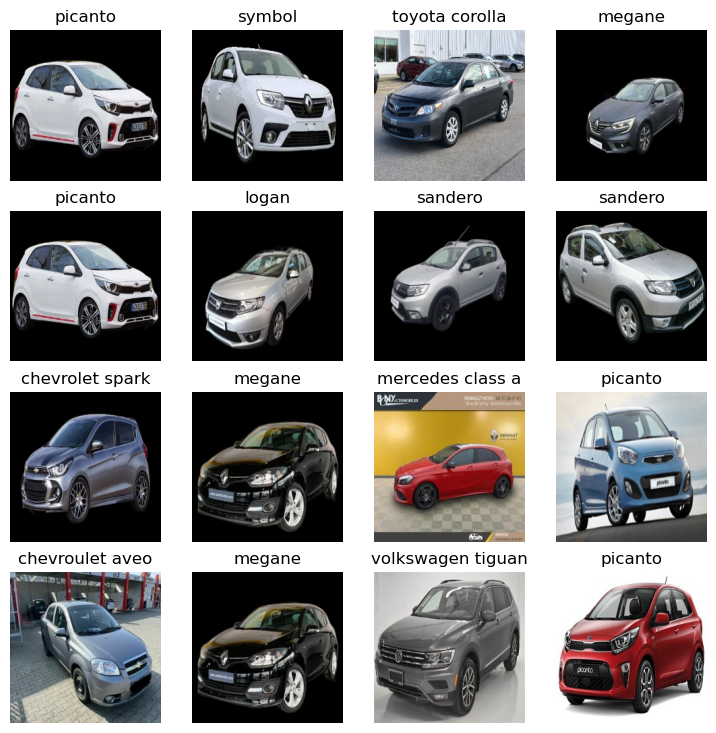

In [12]:
fig = plt.figure(figsize = (9,9))


for i in range(1, ROWS*COLS+1):
    random_idx = torch.randint(0, len(train_image_batch), size = [1]).item()
    img_data, label = train_image_batch[random_idx], train_image_label[random_idx]
    img = np.transpose(img_data.squeeze(), (1,2,0))
    fig.add_subplot(ROWS, COLS, i)
    plt.imshow(img)
    plt.title(class_names[label.argmax()])
    plt.axis('Off')

In [13]:
model_0 = CarClassifierV0(len(class_names), mean = mean, std = std)

In [14]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = model_0.parameters(), lr=1e-2)

In [15]:
model_0

CarClassifierV0(
  (normalize): Normalize(mean=tensor([0.3268, 0.3253, 0.3268]), std=tensor([0.3294, 0.3270, 0.3285]))
  (input_layer): Sequential(
    (0): Conv2d(3, 32, kernel_size=(11, 11), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (features): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
  )
  (output): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=141376, out_features=1000, bias=True)
    (2): ReLU()
    (3): Linear(in_features=1000, out_features=64, bias=True)
    (4): ReLU()
    (5): Linear(in_features=64, out_features=20, bias=True)
  )
)

In [16]:
numel_list = [p.numel() for p in model_0.parameters()]
sum(numel_list)

141607740

In [17]:
pred = model_0(train_image_batch[0].unsqueeze(dim = 0))

In [18]:
train_image_batch[0].unsqueeze(dim = 0).shape

torch.Size([1, 3, 224, 224])

In [19]:
pred.shape, train_image_label[0].shape

(torch.Size([1, 20]), torch.Size([20]))

In [20]:
torch.softmax(pred, dim = 1)

tensor([[0.0492, 0.0498, 0.0461, 0.0516, 0.0543, 0.0550, 0.0491, 0.0537, 0.0489,
         0.0505, 0.0551, 0.0486, 0.0435, 0.0484, 0.0512, 0.0453, 0.0462, 0.0506,
         0.0487, 0.0541]], grad_fn=<SoftmaxBackward0>)

In [21]:
loss = criterion(torch.softmax(pred, dim = 1).squeeze(), train_image_label[0])

In [22]:
loss

tensor(2.9914, grad_fn=<DivBackward1>)

In [23]:
history = fit(5,  model_0, train_dl, test_dl, criterion, optimizer, device = 'cpu')

  0%|          | 0/5 [00:00<?, ?it/s]

Epochs: 0
looked at 0/2264 samples
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]])
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]])
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]])
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]])
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]])
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         1., 0.]])
tensor([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]])
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]])
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]])
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

 20%|██        | 1/5 [04:19<17:16, 259.15s/it]

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0., 0.]])
Train Loss -> 0.09 | Test Loss -> 0.01
Epochs: 1
looked at 0/2264 samples
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]])
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]])
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]])
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]])
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]])
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         1., 0.]])
tensor([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]])
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]])
tensor([[0., 0., 0., 0., 0

 40%|████      | 2/5 [08:47<13:13, 264.46s/it]

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0., 0.]])
Train Loss -> 0.09 | Test Loss -> 0.01
Epochs: 2
looked at 0/2264 samples
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]])
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]])
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]])
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]])
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]])
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         1., 0.]])
tensor([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]])
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]])
tensor([[0., 0., 0., 0., 0

 60%|██████    | 3/5 [13:00<08:38, 259.13s/it]

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0., 0.]])
Train Loss -> 0.09 | Test Loss -> 0.01
Epochs: 3
looked at 0/2264 samples
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]])
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]])
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]])
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]])
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]])
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         1., 0.]])
tensor([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]])
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]])
tensor([[0., 0., 0., 0., 0

 80%|████████  | 4/5 [17:34<04:25, 265.18s/it]

tensor([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]])
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]])
tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]])
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0., 0.]])
Train Loss -> 0.09 | Test Loss -> 0.01
Epochs: 4
looked at 0/2264 samples
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]])
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]])
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]])
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]])
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]])
tensor([[0., 0., 0., 0., 0

100%|██████████| 5/5 [22:38<00:00, 271.69s/it]

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0., 0.]])
Train Loss -> 0.09 | Test Loss -> 0.01


In [24]:
history

{'train_loss': [tensor(0.0856, grad_fn=<DivBackward0>),
  tensor(0.0856, grad_fn=<DivBackward0>),
  tensor(0.0856, grad_fn=<DivBackward0>),
  tensor(0.0856, grad_fn=<DivBackward0>),
  tensor(0.0856, grad_fn=<DivBackward0>),
  tensor(0.0856, grad_fn=<DivBackward0>),
  tensor(0.0856, grad_fn=<DivBackward0>),
  tensor(0.0856, grad_fn=<DivBackward0>),
  tensor(0.0856, grad_fn=<DivBackward0>),
  tensor(0.0856, grad_fn=<DivBackward0>),
  tensor(0.0856, grad_fn=<DivBackward0>),
  tensor(0.0856, grad_fn=<DivBackward0>),
  tensor(0.0856, grad_fn=<DivBackward0>),
  tensor(0.0856, grad_fn=<DivBackward0>),
  tensor(0.0856, grad_fn=<DivBackward0>),
  tensor(0.0856, grad_fn=<DivBackward0>),
  tensor(0.0856, grad_fn=<DivBackward0>),
  tensor(0.0856, grad_fn=<DivBackward0>),
  tensor(0.0856, grad_fn=<DivBackward0>),
  tensor(0.0856, grad_fn=<DivBackward0>),
  tensor(0.0856, grad_fn=<DivBackward0>),
  tensor(0.0856, grad_fn=<DivBackward0>),
  tensor(0.0856, grad_fn=<DivBackward0>),
  tensor(0.0856, gra

In [25]:
loss_plot(history=history)

KeyError: 'epochs'

In [31]:
torch.tensor(10).detach().numpy()

array(10)